# Part 3.1 Modelling with Counttvectorizer

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, RocCurveDisplay, plot_roc_curve, roc_auc_score, recall_score, precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import random
import time

import pickle

pd.options.display.max_columns = None

In [2]:
with open('./pickled_df/preprocess_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.head()

,title,text,subject,date,target,title_text
0,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,2015-03-31,1,benghazi panel call hillary testify oath white...
1,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,left-news,2015-03-31,1,hillary rodham nixon candidate baggage samsoni...
2,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",left-news,2015-03-31,1,watch dirty harry reid lie romneys tax didnt w...
3,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,politics,2015-03-31,1,oh guess funded shrine ted kennedy nothing lik...
4,FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...,Just making room for Hillary President Obama t...,politics,2015-03-31,1,flashback king obama commute sentence drug dea...


### Train Test Split

In [4]:
#df = df.sample(n=100, random_state=42)

In [5]:
df.shape

(39097, 6)

In [6]:
# Setting up the predictors and target variables
X = df["title_text"]
y = df["target"]

In [7]:
X.head()

0    benghazi panel call hillary testify oath white...
1    hillary rodham nixon candidate baggage samsoni...
2    watch dirty harry reid lie romneys tax didnt w...
3    oh guess funded shrine ted kennedy nothing lik...
4    flashback king obama commute sentence drug dea...
Name: title_text, dtype: object

In [8]:
# Train-test-split, 70-30 split.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

In [9]:
X_train.head()

20589    watch trump attorney flatout admits trump admi...
8935     panel report reignites debate clinton benghazi...
19344    cnn panel erupts get ugly guest defends trump ...
23898    stalled russia sanction bill hit north korean ...
14711    porous texas border fence foreshadows challeng...
Name: title_text, dtype: object

In [10]:
#check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27367,), (11730,), (27367,), (11730,))

In [11]:
y_train.value_counts(normalize = True)

0    0.542149
1    0.457851
Name: target, dtype: float64

### Feature Engineering
- Find common features from X_train, remove irrelevant and high occurring words

In [12]:
# Instantiating the count vectorizer
cvec = CountVectorizer(analyzer='word',
                       tokenizer = None,
                       preprocessor = None, 
                       stop_words = None,
                       max_features = 2000)

# Masking the vectorizer with English stop words
cvec = CountVectorizer(stop_words = "english")

# Fit-transforming the vectorizer
cvec_X_train = cvec.fit_transform(X_train)

In [13]:
# Saving the vectorized dfs to a new dataframe
cvec_X_train = pd.DataFrame(cvec_X_train.toarray(), columns = cvec.get_feature_names_out())

# Getting the 15 most frequent words from each
top_20 = pd.DataFrame(cvec_X_train.sum().sort_values(ascending = False).head(20))

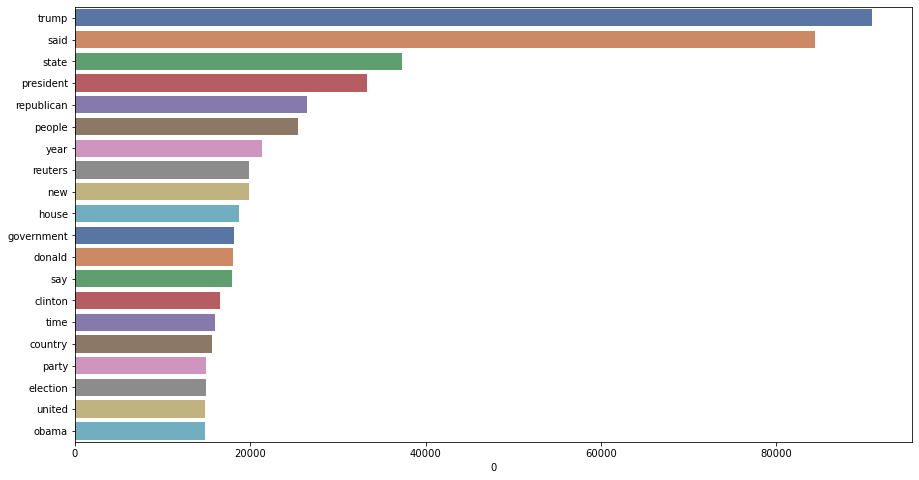

In [14]:
fig = plt.figure(figsize = (15,8), facecolor = "white")
sns.barplot(x= 0,y= top_20.index,
                    data    = top_20,
                    palette = "deep");

In [15]:
add_excluded_words = ['trump','said', 'state', 'president', 'republican',
                      'people', 'year', 'reuters','new','house',
                      'government','donald','say', 'clinton', 'time',
                      'country', 'party', 'election', 'united', 'obama'
                      ]

## Modelling

In [17]:
def convert(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [18]:
#Initialise Confusion Matrix visualisation
def create_cm(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix \n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['True News','Fake News'])
    ax.yaxis.set_ticklabels(['True News','Fake News'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [19]:
#Create a dictionary to house the different models score
results = {}

#create dictionary to house metrics for AUC ROC curve
auc_roc_curve = {}

In [20]:
def best_parameter(model,text_feature):
    
    modelname = str(model) #convert model name to string
    
    import time
    start = time.time() #start timer 

    #setup pipeline:
    pipe = Pipeline([
        ('tf', text_feature),
        ('mdl', model)
    ])
        
    #setup parameters for each model
    if modelname == 'LogisticRegression()':    
        params = {
            'tf__stop_words': [add_excluded_words],
            'tf__ngram_range': [(1, 1), (1, 2)],
            'tf__max_df': [.85, .9, .95],
            'tf__min_df': [2, 4, 6],
            'tf__max_features': [1000, 2000, 3000],
            'mdl__max_iter':[100,300, 500, 10000],
            'mdl__class_weight': ['balanced']
        }
        
    elif modelname == 'RandomForestClassifier()':
        params = {
            'tf__stop_words': [add_excluded_words],
            'tf__ngram_range': [(1, 1), (1, 2)],
            'tf__max_df': [.85, .9],
            'tf__min_df': [2, 4],
            'tf__max_features': [1000, 2000],
            'mdl__n_estimators': [25, 50],
            'mdl__max_features': ['auto', 'log2'],
            'mdl__max_depth': [20, 50],
            'mdl__min_samples_leaf': [2, 3],
            'mdl__min_samples_split': [3, 5],
            'mdl__bootstrap': [True, False],
            'mdl__class_weight': ['balanced']
        }
        
    elif modelname == 'DecisionTreeClassifier()':
        params = {
            'tf__stop_words': [add_excluded_words],
            'tf__ngram_range': [(1, 1), (1, 2)],
            'tf__max_df': [.85, .9],
            'tf__min_df': [2, 4],
            'tf__max_features': [1000, 2000],
            'mdl__criterion' : ['gini', 'entropy'],
            'mdl__max_depth': [20, 50],
            'mdl__min_samples_leaf': [2, 3],
            'mdl__min_samples_split': [3, 5],
            'mdl__class_weight': ['balanced']
        }        
        
    elif modelname == 'MultinomialNB()':
        params = {
            'tf__stop_words': [add_excluded_words],
            'tf__ngram_range': [(1, 1), (1, 2)],
            'tf__max_df': [.85, .9],
            'tf__min_df': [2, 4],
            'tf__max_features': [1000, 2000],
            'mdl__alpha': [1, .5]
        }        
    
    elif modelname == 'KNeighborsClassifier()':
        params = {
            'tf__stop_words': [add_excluded_words],
            'tf__ngram_range': [(1, 1), (1, 2)],
            'tf__max_df': [.85, .9],
            'tf__min_df': [2, 4],
            'tf__max_features': [1000, 2000],
            'mdl__n_neighbors': [3, 5, 7],
            'mdl__weights': ['uniform', 'distance']
        }
        
    elif modelname == 'AdaBoostClassifier()':
        params = {
            'tf__stop_words': [add_excluded_words],
            'tf__ngram_range': [(1, 1), (1, 2)],
            'tf__max_df': [.85, .9],
            'tf__min_df': [2, 4],
            'tf__max_features': [1000, 2000],
            'mdl__learning_rate': [0.5, 1],
            'mdl__n_estimators': [200, 500]
        }
        
    elif modelname == 'GradientBoostingClassifier()':
        params = {
            'tf__stop_words': [add_excluded_words],
            'tf__ngram_range': [(1, 1), (1, 2)],
            'tf__max_df': [.85, .9],
            'tf__min_df': [2, 4],
            'tf__max_features': [1000, 2000],
            'mdl__n_estimators': [10, 50],
            'mdl__max_depth':[3, 5,],
            'mdl__learning_rate': [0.01, 1],
            'mdl__min_samples_split' : [3, 5],
            'mdl__min_samples_leaf' : [1, 3],
            'mdl__max_features': ['auto']
                              
        }
    
    #using GridSearchCV to get the most optimised parameters
    gs = RandomizedSearchCV(pipe, param_distributions=params, n_iter = 100, cv=3, n_jobs=-1, verbose = 1)
    gs.fit(X_train, y_train)
    
    print('best score:', gs.best_score_)
    print('best params:', gs.best_params_)
    
    #Score model on Training data
    train_score = round(gs.score(X_train, y_train),3)
    print('Score on Training Data:', train_score)
    
    # Score model on Testing data
    test_score = round(gs.score(X_test, y_test),3)
    print('Score on Testing Data:', test_score)
    
    # Generalisation Score
    generalisation = round((train_score - test_score)*100/train_score,3)
    print('Generalisation Score:', generalisation)
    
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    
    # Calculate ROC_AUC score
    y_proba = gs.predict_proba(X_test)
    auc = round(roc_auc_score(y_test, y_proba[:,1]),4)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc_metrics = round(metrics.roc_auc_score(y_test, y_pred),3)

    
    # Confusion matrix
    create_cm(y_test, y_pred)
    
    # Save performance metrics value
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Print the different metrics
    accuracy = round(accuracy_score(y_test, y_pred),3) # Accuracy 
    print('Accuracy:', accuracy)
    precision = round(tp / (tp + fp),3) # Precision (Positive Predictive Value)
    print('Precision:', precision)
    recall = round(tp / (tp + fn),3) # Recall (Sensitivity, True Positive Rate)
    print('Recall:', recall)
    specificity = round(tn / (tn + fp),3) # Specificity (True Negative Rate)
    f1 = round(2 * (precision * recall) / (precision + recall),3) #F1
    print('F1:', f1)
    print('ROC AUC:', auc)
    
    #execution time
    end = time.time()
    execution_time = convert(end - start)
    print('Execution time is:',execution_time)
    
    #store result in dataframe
    modelname = modelname[:-2]
    txtfeat = str(text_feature)
    txtfeat = txtfeat[:-2]
    model_txtfeat = modelname+'_'+txtfeat
    results[model_txtfeat] = [train_score, test_score, generalisation, accuracy, precision, recall, specificity, f1, auc, execution_time]
    auc_roc_curve[model_txtfeat] =[auc_metrics, fpr, tpr]
    
    # pickle the model
    gs_file = './models/gs_'+model_txtfeat+'.sav'
    pickle.dump(gs.best_params_, open(gs_file, 'wb'))
    

#### Baseline Model

In [21]:
vect = CountVectorizer(stop_words = add_excluded_words)
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

Score on Training Data: 1.0
Score on Testing Data: 0.981
Generalisation Score: 1.9


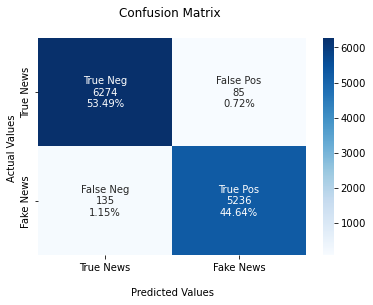

In [22]:
LR = LogisticRegression(max_iter = 1000)
LR.fit(X_train_vect, y_train)
LR.score(X_test_vect, y_test)
y_pred = LR.predict(X_test_vect)

#Score model on Training data
train_score = round(LR.score(X_train_vect, y_train),3)
print('Score on Training Data:', train_score)
    
# Score model on Testing data
test_score = round(LR.score(X_test_vect, y_test),3)
print('Score on Testing Data:', test_score)
    
# Generalisation Score
generalisation = round((train_score - test_score)*100/train_score,3)
print('Generalisation Score:', generalisation)
    
# Create CM
create_cm(y_test, y_pred)

#### LogisticRegression

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\rohaz\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


best score: 0.9753352176718981
best params: {'tf__stop_words': ['trump', 'said', 'state', 'president', 'republican', 'people', 'year', 'reuters', 'new', 'house', 'government', 'donald', 'say', 'clinton', 'time', 'country', 'party', 'election', 'united', 'obama'], 'tf__ngram_range': (1, 2), 'tf__min_df': 4, 'tf__max_features': 3000, 'tf__max_df': 0.95, 'mdl__max_iter': 100, 'mdl__class_weight': 'balanced'}
Score on Training Data: 1.0
Score on Testing Data: 0.976
Generalisation Score: 2.4


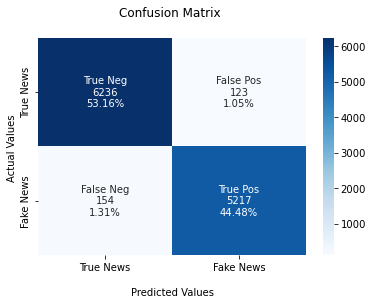

Accuracy: 0.976
Precision: 0.977
Recall: 0.971
F1: 0.974
ROC AUC: 0.9946
Execution time is: 00:27:59


In [23]:
best_parameter(LogisticRegression(), CountVectorizer())

#### RandomForestClassifier

Fitting 3 folds for each of 100 candidates, totalling 300 fits
best score: 0.9668213714540387
best params: {'tf__stop_words': ['trump', 'said', 'state', 'president', 'republican', 'people', 'year', 'reuters', 'new', 'house', 'government', 'donald', 'say', 'clinton', 'time', 'country', 'party', 'election', 'united', 'obama'], 'tf__ngram_range': (1, 2), 'tf__min_df': 2, 'tf__max_features': 2000, 'tf__max_df': 0.9, 'mdl__n_estimators': 50, 'mdl__min_samples_split': 3, 'mdl__min_samples_leaf': 2, 'mdl__max_features': 'auto', 'mdl__max_depth': 50, 'mdl__class_weight': 'balanced', 'mdl__bootstrap': False}
Score on Training Data: 1.0
Score on Testing Data: 0.967
Generalisation Score: 3.3


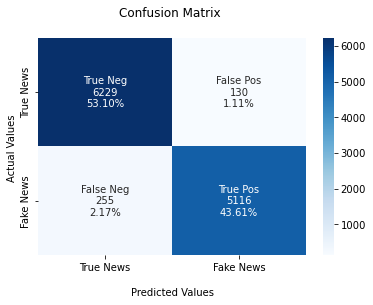

Accuracy: 0.967
Precision: 0.975
Recall: 0.953
F1: 0.964
ROC AUC: 0.995
Execution time is: 00:59:59


In [24]:
best_parameter(RandomForestClassifier(), CountVectorizer())

#### DecisionTreeClassifier

Fitting 3 folds for each of 100 candidates, totalling 300 fits
best score: 0.9182227768644958
best params: {'tf__stop_words': ['trump', 'said', 'state', 'president', 'republican', 'people', 'year', 'reuters', 'new', 'house', 'government', 'donald', 'say', 'clinton', 'time', 'country', 'party', 'election', 'united', 'obama'], 'tf__ngram_range': (1, 2), 'tf__min_df': 4, 'tf__max_features': 2000, 'tf__max_df': 0.85, 'mdl__min_samples_split': 5, 'mdl__min_samples_leaf': 2, 'mdl__max_depth': 20, 'mdl__criterion': 'gini', 'mdl__class_weight': 'balanced'}
Score on Training Data: 0.969
Score on Testing Data: 0.919
Generalisation Score: 5.16


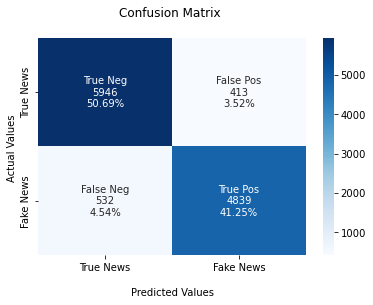

Accuracy: 0.919
Precision: 0.921
Recall: 0.901
F1: 0.911
ROC AUC: 0.9226
Execution time is: 00:49:16


In [25]:
best_parameter(DecisionTreeClassifier(), CountVectorizer())

#### MultinomialNB

C:\Users\rohaz\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 32 candidates, totalling 96 fits
best score: 0.9322540904407047
best params: {'tf__stop_words': ['trump', 'said', 'state', 'president', 'republican', 'people', 'year', 'reuters', 'new', 'house', 'government', 'donald', 'say', 'clinton', 'time', 'country', 'party', 'election', 'united', 'obama'], 'tf__ngram_range': (1, 2), 'tf__min_df': 4, 'tf__max_features': 2000, 'tf__max_df': 0.85, 'mdl__alpha': 0.5}
Score on Training Data: 0.934
Score on Testing Data: 0.933
Generalisation Score: 0.107


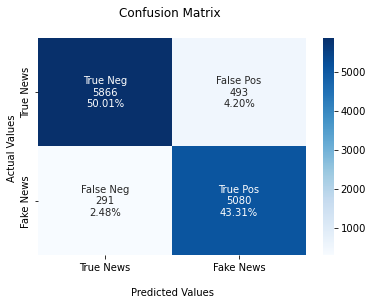

Accuracy: 0.933
Precision: 0.912
Recall: 0.946
F1: 0.929
ROC AUC: 0.9698
Execution time is: 00:15:08


In [26]:
best_parameter(MultinomialNB(), CountVectorizer())

#### KNeighborsClassifier

C:\Users\rohaz\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 96 is smaller than n_iter=100. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 96 candidates, totalling 288 fits
best score: 0.7810499797368435
best params: {'tf__stop_words': ['trump', 'said', 'state', 'president', 'republican', 'people', 'year', 'reuters', 'new', 'house', 'government', 'donald', 'say', 'clinton', 'time', 'country', 'party', 'election', 'united', 'obama'], 'tf__ngram_range': (1, 2), 'tf__min_df': 2, 'tf__max_features': 1000, 'tf__max_df': 0.85, 'mdl__weights': 'distance', 'mdl__n_neighbors': 3}
Score on Training Data: 1.0
Score on Testing Data: 0.788
Generalisation Score: 21.2


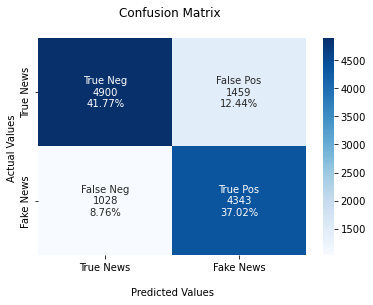

Accuracy: 0.788
Precision: 0.749
Recall: 0.809
F1: 0.778
ROC AUC: 0.8453
Execution time is: 01:32:25


In [27]:
best_parameter(KNeighborsClassifier(), CountVectorizer())

#### AdaBoostClassifier

C:\Users\rohaz\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 64 is smaller than n_iter=100. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 64 candidates, totalling 192 fits
best score: 0.9798662835953172
best params: {'tf__stop_words': ['trump', 'said', 'state', 'president', 'republican', 'people', 'year', 'reuters', 'new', 'house', 'government', 'donald', 'say', 'clinton', 'time', 'country', 'party', 'election', 'united', 'obama'], 'tf__ngram_range': (1, 2), 'tf__min_df': 2, 'tf__max_features': 2000, 'tf__max_df': 0.85, 'mdl__n_estimators': 500, 'mdl__learning_rate': 0.5}
Score on Training Data: 0.988
Score on Testing Data: 0.979
Generalisation Score: 0.911


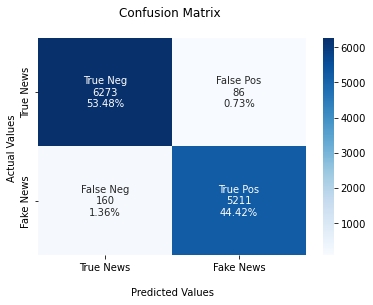

Accuracy: 0.979
Precision: 0.984
Recall: 0.97
F1: 0.977
ROC AUC: 0.9973
Execution time is: 01:34:10


In [28]:
best_parameter(AdaBoostClassifier(), CountVectorizer())

#### GradientBoostingClassifier

Fitting 3 folds for each of 100 candidates, totalling 300 fits
best score: 0.968282995157038
best params: {'tf__stop_words': ['trump', 'said', 'state', 'president', 'republican', 'people', 'year', 'reuters', 'new', 'house', 'government', 'donald', 'say', 'clinton', 'time', 'country', 'party', 'election', 'united', 'obama'], 'tf__ngram_range': (1, 2), 'tf__min_df': 4, 'tf__max_features': 2000, 'tf__max_df': 0.85, 'mdl__n_estimators': 50, 'mdl__min_samples_split': 3, 'mdl__min_samples_leaf': 1, 'mdl__max_features': 'auto', 'mdl__max_depth': 3, 'mdl__learning_rate': 1}
Score on Training Data: 0.981
Score on Testing Data: 0.966
Generalisation Score: 1.529


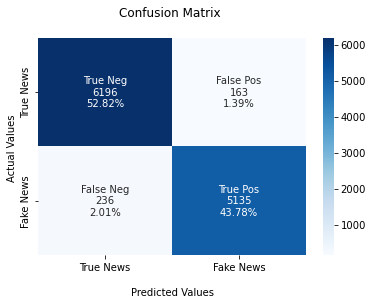

Accuracy: 0.966
Precision: 0.969
Recall: 0.956
F1: 0.962
ROC AUC: 0.9924
Execution time is: 01:31:48


In [29]:
best_parameter(GradientBoostingClassifier(), CountVectorizer())

## AUC ROC Curve

In [30]:
auc_roc_curve_df_cvec = pd.DataFrame(auc_roc_curve, index=['auc_metrics', 'fpr', 'tpr']).T

with open('./pickled_df/auc_roc_curve_df_cvec.pkl', 'wb') as f:
    pickle.dump(auc_roc_curve_df_cvec, f),
    
    
auc_roc_curve_df_cvec

,auc_metrics,fpr,tpr
LogisticRegression_CountVectorizer,0.976,"[0.0, 0.019342663940871207, 1.0]","[0.0, 0.9713274995345373, 1.0]"
RandomForestClassifier_CountVectorizer,0.966,"[0.0, 0.020443465953766317, 1.0]","[0.0, 0.9525228076708248, 1.0]"
DecisionTreeClassifier_CountVectorizer,0.918,"[0.0, 0.06494731876081145, 1.0]","[0.0, 0.9009495438465835, 1.0]"
MultinomialNB_CountVectorizer,0.934,"[0.0, 0.07752791319389842, 1.0]","[0.0, 0.945820145224353, 1.0]"
KNeighborsClassifier_CountVectorizer,0.79,"[0.0, 0.2294385909734235, 1.0]","[0.0, 0.8086017501396388, 1.0]"
AdaBoostClassifier_CountVectorizer,0.978,"[0.0, 0.013524139015568485, 1.0]","[0.0, 0.970210389126792, 1.0]"
GradientBoostingClassifier_CountVectorizer,0.965,"[0.0, 0.025632961157414688, 1.0]","[0.0, 0.9560603239620182, 1.0]"


In [31]:
#define function to get value from auc_roc_curve_df
def curve_filter(model,col):
    return auc_roc_curve_df_cvec.loc[model, col]

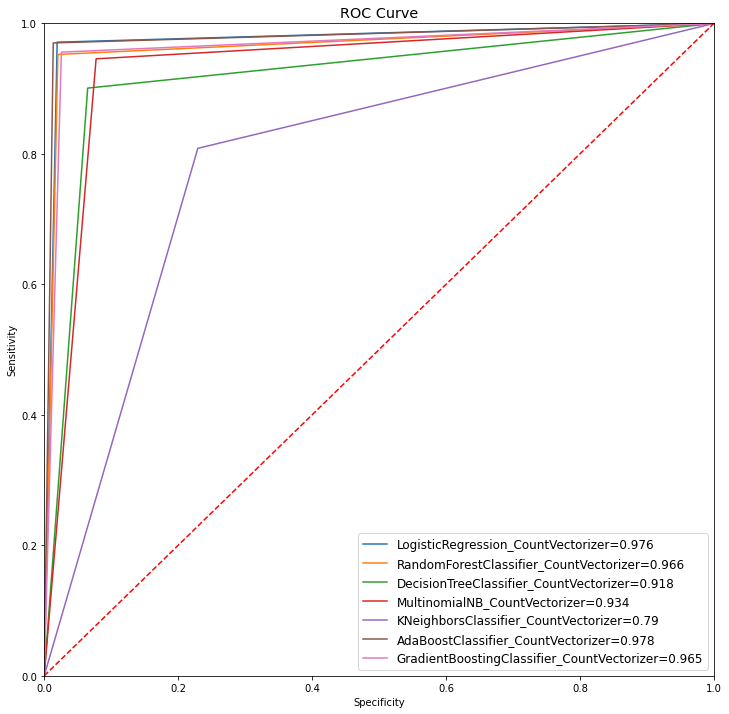

In [32]:
#plot ROC curves
plt.figure(figsize=(12,12))
#create ROC curve

plt.plot(curve_filter('LogisticRegression_CountVectorizer','fpr'),
         curve_filter('LogisticRegression_CountVectorizer','tpr'),
         label="LogisticRegression_CountVectorizer="+str(curve_filter('LogisticRegression_CountVectorizer','auc_metrics')))
plt.plot(curve_filter('RandomForestClassifier_CountVectorizer','fpr'),
         curve_filter('RandomForestClassifier_CountVectorizer','tpr'),
         label="RandomForestClassifier_CountVectorizer="+str(curve_filter('RandomForestClassifier_CountVectorizer','auc_metrics')))
plt.plot(curve_filter('DecisionTreeClassifier_CountVectorizer','fpr'),
         curve_filter('DecisionTreeClassifier_CountVectorizer','tpr'),
         label="DecisionTreeClassifier_CountVectorizer="+str(curve_filter('DecisionTreeClassifier_CountVectorizer','auc_metrics')))
plt.plot(curve_filter('MultinomialNB_CountVectorizer','fpr'),
         curve_filter('MultinomialNB_CountVectorizer','tpr'),
         label="MultinomialNB_CountVectorizer="+str(curve_filter('MultinomialNB_CountVectorizer','auc_metrics')))
plt.plot(curve_filter('KNeighborsClassifier_CountVectorizer','fpr'),
         curve_filter('KNeighborsClassifier_CountVectorizer','tpr'),
         label="KNeighborsClassifier_CountVectorizer="+str(curve_filter('KNeighborsClassifier_CountVectorizer','auc_metrics')))
plt.plot(curve_filter('AdaBoostClassifier_CountVectorizer','fpr'),
         curve_filter('AdaBoostClassifier_CountVectorizer','tpr'),
         label="AdaBoostClassifier_CountVectorizer="+str(curve_filter('AdaBoostClassifier_CountVectorizer','auc_metrics')))
plt.plot(curve_filter('GradientBoostingClassifier_CountVectorizer','fpr'),
         curve_filter('GradientBoostingClassifier_CountVectorizer','tpr'),
         label="GradientBoostingClassifier_CountVectorizer="+str(curve_filter('GradientBoostingClassifier_CountVectorizer','auc_metrics')))
# Set limit
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12

# Plot random
plt.plot([0, 1], [0, 1],'r--')

# axis labels
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')

# show title
plt.title("ROC Curve")

plt.legend(loc=4)
plt.show()

## Result Evaluation

In [33]:
results_df_cvec = pd.DataFrame(results, index=['Train score', 'Test score', 'Generalisation','Accuracy', 'Precision', 'Recall', 'Specificity','F1', 'ROC AUC', 'Execution Time']).T

with open('./pickled_df/results_df_cvec.pkl', 'wb') as f:
    pickle.dump(results_df_cvec, f)
    
results_df_cvec                            
#print(results_df.to_markdown(index=False))

,Train score,Test score,Generalisation,Accuracy,Precision,Recall,Specificity,F1,ROC AUC,Execution Time
LogisticRegression_CountVectorizer,1.0,0.976,2.4,0.976,0.977,0.971,0.981,0.974,0.9946,00:27:59
RandomForestClassifier_CountVectorizer,1.0,0.967,3.3,0.967,0.975,0.953,0.98,0.964,0.995,00:59:59
DecisionTreeClassifier_CountVectorizer,0.969,0.919,5.16,0.919,0.921,0.901,0.935,0.911,0.9226,00:49:16
MultinomialNB_CountVectorizer,0.934,0.933,0.107,0.933,0.912,0.946,0.922,0.929,0.9698,00:15:08
KNeighborsClassifier_CountVectorizer,1.0,0.788,21.2,0.788,0.749,0.809,0.771,0.778,0.8453,01:32:25
AdaBoostClassifier_CountVectorizer,0.988,0.979,0.911,0.979,0.984,0.97,0.986,0.977,0.9973,01:34:10
GradientBoostingClassifier_CountVectorizer,0.981,0.966,1.529,0.966,0.969,0.956,0.974,0.962,0.9924,01:31:48
